# Capstone Project

## Loading libraries

First step is to make sure all of these python libraries are available for usage

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
from PIL import Image
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import os
import urllib
%matplotlib inline

/Users/thalles/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the required datasets.

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename):
  """Download a file if not present"""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
    print filename, "download completed."
  else:
    print 'Filename:', filename, 'is already downloaded.'
  return filename

# download the datasets if necessary
train_dataset_filename = maybe_download("train_32x32.mat")
test_dataset_filename = maybe_download("test_32x32.mat")
extra_dataset_filename = maybe_download("extra_32x32.mat")

Filename: train_32x32.mat is already downloaded.
Filename: test_32x32.mat is already downloaded.
extra_32x32.mat download completed.


Load the training and testing sets.

In [ ]:
raw_train_data = sio.loadmat(train_dataset_filename)
raw_test_data = sio.loadmat(test_dataset_filename)
#raw_extra_data = sio.loadmat(extra_dataset_filename)

train_dataset, train_labels = raw_test_data["X"], raw_test_data["y"]
test_dataset, test_labels = raw_train_data["X"], raw_train_data["y"]
#extra_dataset, extra_labels = raw_extra_data["X"], raw_extra_data["y"]

# free up memory from the notebook cache
%xdel raw_train_data
%xdel raw_extra_data
#%xdel raw_test_data

print train_dataset.shape
print train_labels.shape
print test_dataset.shape
print test_labels.shape

## Image processing

Reshape the datasets for better index accessing

In [37]:
image_size = 32  # Pixel width and height.
number_of_channels = 3

def reshape_dataset(data, n_of_images):
    dataset = np.ndarray(shape=(n_of_images, image_size, image_size, number_of_channels), dtype=np.uint8) 
    for index in range(0,n_of_images):
        dataset[index,:,:,:] = data[:,:,:,index]
    return dataset
    
train_dataset = reshape_dataset(train_dataset, 26032)
test_dataset = reshape_dataset(test_dataset, 73257)

print train_dataset.shape
print train_labels.shape
print test_dataset.shape
print test_labels.shape

(26032, 32, 32, 3)
(26032, 1)
(73257, 32, 32, 3)
(73257, 1)


Display some of the images just to make sure everything is fine.

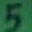

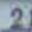

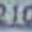

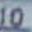

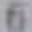

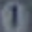

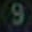

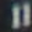

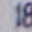

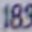

In [38]:
# display the first n images
for i in range(0,10):
    img = train_dataset[i,:,:,:]
    display(Image.fromarray(img, 'RGB'))

Try to normilize the images to have mean close to 0 and standard deviations roughly 0.5

Mean: -6.20882e-09
Standard deviation: 1.0
Mean: -0.245944
Standard deviation: 0.111617


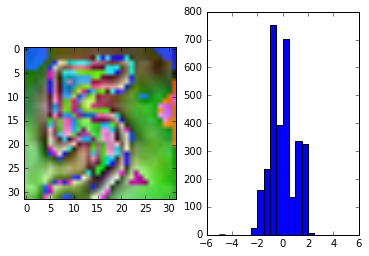

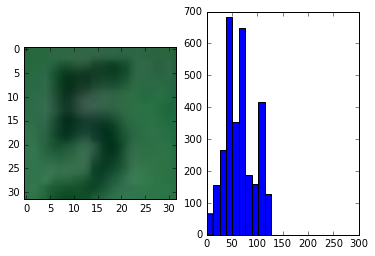

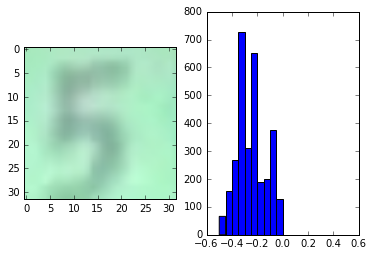

In [39]:
pixel_depth = 255.0  # Number of levels per pixel.

image = train_dataset[0] # get the first image

sess = tf.Session()
img = tf.image.per_image_whitening(tf.convert_to_tensor(image))
img = img.eval(session=sess)

print 'Mean:', np.mean(img)
print 'Standard deviation:', np.std(img)

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap=plt.cm.Greys);
ax2.hist(np.reshape(img,3072), bins=20, range=[-5,5]);

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image, cmap=plt.cm.Greys);
ax2.hist(np.reshape(image,3072), bins=20, range=[0,255]);

scalar = image.astype(np.float32)
scalar = np.reshape(scalar, 3072)
scalar = ((scalar - pixel_depth / 2.0) / pixel_depth)
image = np.reshape(scalar, (32,32,3))

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image, cmap=plt.cm.Greys);
ax2.hist(scalar, bins=20, range=[-0.5, 0.5]);

print 'Mean:', np.mean(image)
print 'Standard deviation:', np.std(image)

## Labels processing

According to the dataset specs, in the SVHN dataset, there are 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Let's convert each of the images of 0s to have a class label of '0' instead of '10'.

In [40]:
for index in range(0,train_labels.size):
    if train_labels[index] == 10:
        train_labels[index] = 0
        
for index in range(0,test_labels.size):
    if test_labels[index] == 10:
        test_labels[index] = 0

# reshape the labels to be 1-D array
train_labels = train_labels.reshape(train_labels.size)
test_labels = test_labels.reshape(test_labels.size)

Another check: we expect the data to be balanced across classes.

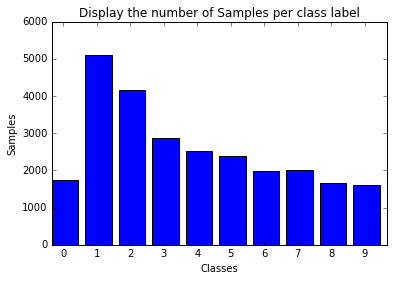

In [41]:
# verify if the data is well balanced across the classes
def display_data_distribution(labels):
    data_distribution = np.bincount(labels)

    index = np.arange(10)
    plt.bar(index, data_distribution)
    plt.title("Display the number of Samples per class label")
    plt.xlabel('Classes')
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

    plt.show()
    
display_data_distribution(train_labels)

As we can see, the distribution of images per class is not well balanced. There are much more images of class 1 than any other. Also, we notice that theere are more than twice more images from class '1' than from class '0', '6', '7', '8', and '9'.

Let's remove some images to make the classes more well balanced.

(19632,)


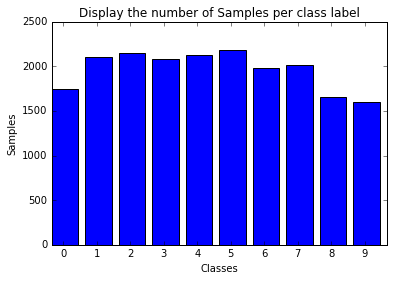

In [42]:
import random

data_distribution = np.bincount(train_labels)
limit = 5000
indexes = list(range(len(extra_labels)))

for index in random.shuffle(indexes):
    if data_distribution[extra_labels[index]] < limit:
        train_data.append(extra_dataset[index])
        train_label.append(extra_labels[index])

Let's move on to loading the full set of labels. As is typical in classification problems, we'll convert our input labels into a [1-hot](https://en.wikipedia.org/wiki/One-hot) encoding over a length 10 vector corresponding to 10 digits. The vector [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], for example, would correspond to the digit 1.

In [46]:
NUM_LABELS = 10

def convert_to_one_hot(labels):
    return (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float32)

# convert the image labels to onehot notation
train_labels_h = convert_to_one_hot(train_labels)
test_labels_h = convert_to_one_hot(test_labels)

Let's check if out 1-hot encondings match our expectations

In [47]:
print 'Training labels shape', train_labels_h.shape
print 'First label vector', train_labels_h[0]
print 'Second label vector', train_labels_h[1]

Training labels shape (26032, 10)
First label vector [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Second label vector [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
